## **Modelo de clasificación de tweets**

In [90]:
import json
import pandas as pd
import os
import string
import re
import logging
import warnings
import datetime
import seaborn as sns
import json
import pandas as pd
import os
import string
import re
import logging
import warnings
import datetime
import mlflow
import logging
import joblib
import pickle

from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer

import emoji
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.decomposition import TruncatedSVD
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from mlflow.models import infer_signature


from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)
import scipy

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings("ignore")


In [2]:
nltk.download('stopwords')
stemmer = SnowballStemmer('english')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df = pd.read_csv('../data/input/twcs.csv')

## **Análisis exploratorio de los datos**

In [4]:
df.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [5]:
df.isnull().sum()

tweet_id                         0
author_id                        0
inbound                          0
created_at                       0
text                             0
response_tweet_id          1040629
in_response_to_tweet_id     794335
dtype: int64

In [6]:
df.drop(["tweet_id"], axis=1, inplace=True)
df.drop(["author_id"], axis=1, inplace=True)
df.drop(["created_at"], axis=1, inplace=True)
df.drop(["response_tweet_id"], axis=1, inplace=True)
df.drop(["in_response_to_tweet_id"], axis=1, inplace=True)

Como primer paso en el análisis de los datos, procedimos a eliminar aquellas columnas que no aportaban información relevante o que no ofrecían ningún insight útil para la resolución del problema. Con el objetivo de simplificar y enfocar el análisis, decidimos conservar únicamente dos variables: inbound y text.

* text: Esta columna contiene el contenido de los tuits. 
* inbound: Esta variable indica si el tuit fue enviado como parte de una interacción hacia una empresa que brinda soporte al cliente a través de Twitter.

Estas variables seleccionadas nos permitirán enfocar el análisis en el contenido de los mensajes y en el contexto de la conversación, elementos clave para el desarrollo de soluciones basadas en procesamiento de lenguaje natural.

In [7]:
df['inbound'] = df['inbound'].astype(bool)
df['text'] = df['text'].astype(str)

In [8]:
df = df[df['inbound']==True]
df = df.reset_index(drop=True)

Filtramos el conjunto de datos para conservar únicamente los tuits que son entrantes hacia una empresa que brinda soporte al cliente en Twitter. Es decir, seleccionamos solo aquellos mensajes enviados por los usuarios a la empresa, lo cual resulta útil para realizar un análisis de sentimientos enfocado en las interacciones iniciadas por los clientes. Esto permite, entre otras cosas, dar mayor prioridad a aquellos usuarios que expresan emociones neutrales o negativas, con el fin de identificar y resolver sus inconvenientes de manera más eficiente.

In [9]:
df.count()

inbound    1537843
text       1537843
dtype: int64

## **Limpieza y preprocesamiento de los datos**

In [10]:
def remove_emoji(texto:str)-> str:
    return emoji.replace_emoji(texto, replace='')

In [11]:
def delete_digitos(texto:str)-> str:
    return ''.join(c for c in texto if not c.isdigit())

In [12]:
def delete_puntuacion(texto:str)-> str:
    return ''.join(c for c in texto if c not in punctuation)

In [13]:
def tokenize(texto: str)-> str:
    tokens = word_tokenize(texto.lower(), language='english')
    return tokens

In [14]:
def remove_stopwords(tokens: list):
    filtered_tokens = [
        word for word in tokens if word.lower() not in stop_words
    ]
    return filtered_tokens

In [15]:
def lemmatize(tokens: list):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [16]:
def procesador_texto(columna_df :pd.Series):
    inicio_time = datetime.datetime.now()
    
    text_sin_emojin = columna_df.apply(remove_emoji)
    text_sin_digitos = text_sin_emojin.apply(delete_digitos)
    text_sin_puntuacion = text_sin_digitos.apply(delete_puntuacion)
    
    tokenized_text = text_sin_puntuacion.apply(tokenize)
    
    stopwords_text = tokenized_text.apply(remove_stopwords)
    
    lemmatize_text = stopwords_text.apply(lemmatize)
    
    fin_time = datetime.datetime.now()
    print(f"time = {fin_time - inicio_time}")
    
    return lemmatize_text

In [17]:
def save_processed_data(df: pd.DataFrame, path: str, file_name: str) -> None:
    file_path = os.path.join(path, file_name)
    df.to_csv(file_path, index=False)
    print(f"Data successfully saved to {file_path}")

In [18]:
text_cls = procesador_texto(df['text'])
df['TextPreproc'] = text_cls


time = 0:10:35.379662


In [19]:
save_processed_data(df,'../data/output','processing_twcs_1.csv')

Data successfully saved to ../data/output\processing_twcs_1.csv


Hasta este punto, hemos realizado los siguientes procedimientos de limpieza en los comentarios de los tuits:

* Eliminación de emojis: Se eliminaron los emojis del texto, ya que el objetivo es realizar un análisis puramente textual del contenido.

* Eliminación de números: Se removieron los números presentes en el texto, ya que no aportan valor significativo para nuestro análisis de sentimientos.

* Eliminación de signos de puntuación: Este paso forma parte del proceso de estandarización del texto, permitiendo tratar todos los signos de puntuación de manera uniforme.

* Tokenización del texto: Aplicamos la técnica de tokenización para dividir el texto en palabras individuales, lo cual facilita el análisis posterior.

* Eliminación de stopwords: Se eliminaron las stopwords, que son palabras vacías (como "el", "de", "y") que no aportan información relevante al análisis semántico.

* Lematización: Finalmente, se aplicó la técnica de lemmatization, que permite reducir las palabras a su forma base o "lema", ayudando a agrupar variaciones gramaticales de una misma palabra.

## Extracción de Features

In [20]:
df_features = pd.read_csv('../data/output/processing_twcs_1.csv')

In [21]:
df_features['inbound'] = df_features['inbound'].astype(bool)
df_features['text'] = df_features['text'].astype(str)
df_features['TextPreproc'] = list(df_features['TextPreproc'])

In [22]:
df_features.head(3)

,inbound,text,TextPreproc
0,True,@sprintcare and how do you propose we do that,"['sprintcare', 'propose']"
1,True,@sprintcare I have sent several private messag...,"['sprintcare', 'sent', 'several', 'private', '..."
2,True,@sprintcare I did.,['sprintcare']


In [33]:
def clsTexto(words: list):
    return " ".join(str(word) for word in words)

In [34]:
def etiquetar_sentimiento(texto:str):
    score = sia.polarity_scores(texto)['compound']
    if score >= 0.05:
        return 'positivo'
    elif score <= -0.05:
        return 'negativo'
    else:
        return 'neutral'

In [ ]:
#df_features['textCls'] = df_features['TextPreproc'].apply(clsTexto)
df['textCls'] = df['TextPreproc'].apply(clsTexto)

In [39]:
df.head(3)

,inbound,text,TextPreproc,textCls
0,True,@sprintcare and how do you propose we do that,"[sprintcare, propose]",sprintcare propose
1,True,@sprintcare I have sent several private messag...,"[sprintcare, sent, several, private, message, ...",sprintcare sent several private message one re...
2,True,@sprintcare I did.,[sprintcare],sprintcare


In [40]:
df['sentimiento'] = df['textCls'].apply(etiquetar_sentimiento)

In [41]:
df.isna().sum()

inbound        0
text           0
TextPreproc    0
textCls        0
sentimiento    0
dtype: int64

In [42]:
conteosFabs = pd.Series(df['sentimiento']).value_counts()
tablaFrecuenciaAbs = pd.DataFrame({'sentimiento': conteosFabs.index, 'Conteo': conteosFabs.values})
tablaFrecuenciaAbs

,sentimiento,Conteo
0,positivo,626693
1,neutral,495395
2,negativo,415755


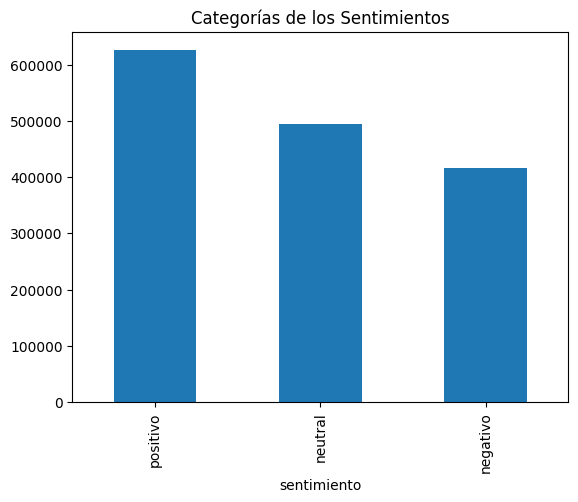

In [43]:
plot = df['sentimiento'].value_counts().plot(kind='bar',
                                            title='Categorías de los Sentimientos')

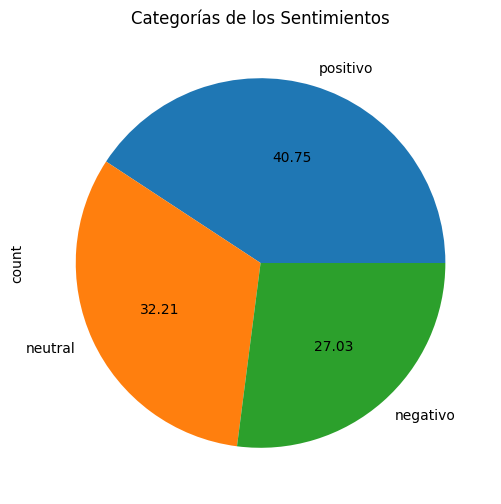

In [45]:
plot2 = df['sentimiento'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Categorías de los Sentimientos')

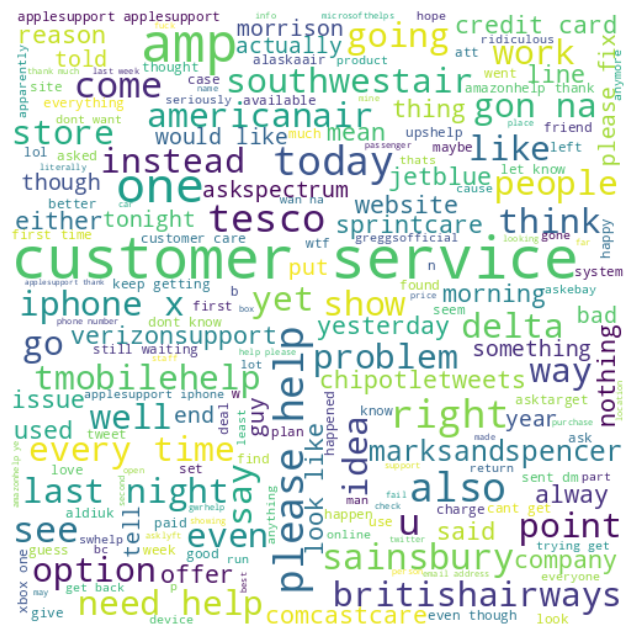

In [46]:
try:
  text = " ".join(str(resp) for resp in df.textCls)
except Exception as e:
  print(e)
  pass

#Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=500, height=500).generate(text)

#Display the generated image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
save_processed_data(df,'../data/output','feature_twcs_1.csv')

Data successfully saved to ../data/output\feature_twcs_1.csv


In [55]:
def plot_ngrams(df: pd.DataFrame, 
                name_column_text: str, 
                name_column_target: str, 
                ngram_range=(2, 3), 
                top_n=5) -> None:
    
    unique_categories = df[name_column_target].unique()[:8]
    fig, axs = plt.subplots(len(unique_categories), 2, figsize=(12, 2 * len(unique_categories)))

    for i, category in enumerate(unique_categories):
        filtered_text = df[df[name_column_target] == category][name_column_text]
        filtered_text = filtered_text.astype(str) 
        
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        X = vectorizer.fit_transform(filtered_text)
        
        # Obtener los n-gramas y su frecuencia
        ngram_freq = list(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))
        ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
        
        bigrams = [ngram[0] for ngram in ngram_freq if len(ngram[0].split()) == 2][:top_n]
        bigram_frequencies = [ngram[1] for ngram in ngram_freq if len(ngram[0].split()) == 2][:top_n]
        
        trigrams = [ngram[0] for ngram in ngram_freq if len(ngram[0].split()) == 3][:top_n]
        trigram_frequencies = [ngram[1] for ngram in ngram_freq if len(ngram[0].split()) == 3][:top_n]

        if bigrams:
            axs[i, 0].barh(bigrams, bigram_frequencies, color='skyblue')
            axs[i, 0].set_xlabel('Frequency')
            axs[i, 0].set_title(f'Top {top_n} Bigrams:\n{category[:45]}...', fontsize=6)
            axs[i, 0].invert_yaxis()

            for j, freq in enumerate(bigram_frequencies):
                axs[i, 0].text(freq, j, str(freq), ha='left', va='center')

        if trigrams:
            axs[i, 1].barh(trigrams, trigram_frequencies, color='salmon')
            axs[i, 1].set_xlabel('Frequency')
            axs[i, 1].set_title(f'Top {top_n} Trigrams:\n{category[:45]}...', fontsize=6)
            axs[i, 1].invert_yaxis()

            for j, freq in enumerate(trigram_frequencies):
                axs[i, 1].text(freq, j, str(freq), ha='left', va='center')

    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()

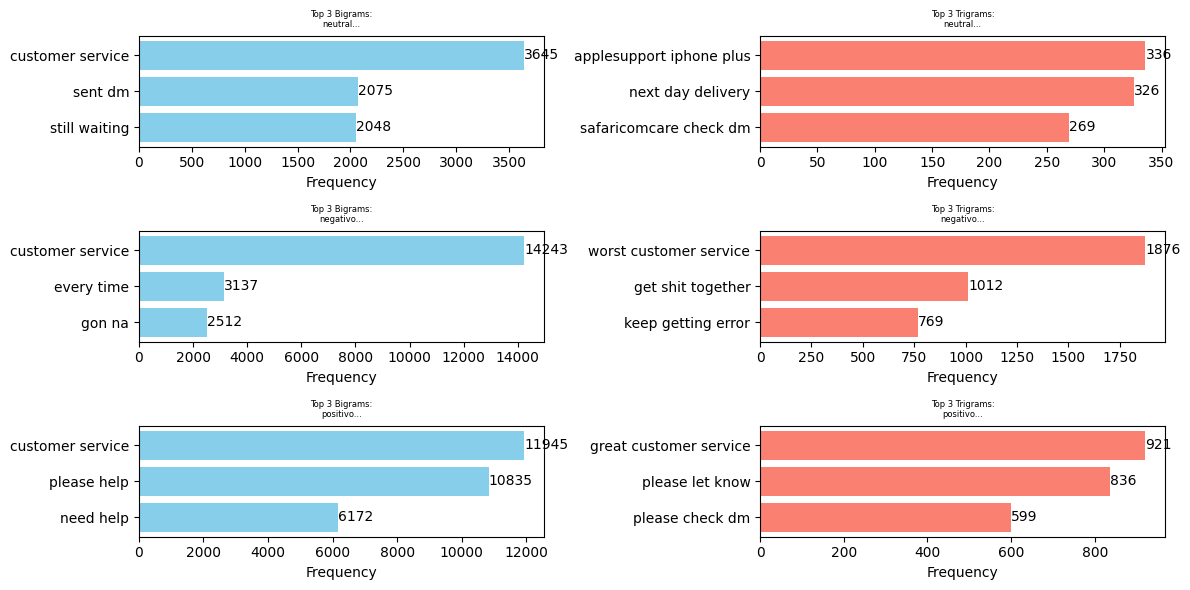

In [57]:
plot_ngrams(df, "textCls", "sentimiento", ngram_range=(2, 3), top_n=3)


In [63]:
df['token_count'] = df['textCls'].apply(len)

In [ ]:
def plot_token_count_kde(df, column_name):
    # Grafica una estimación de densidad de kernel (KDE) de recuentos de tokens
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[column_name], color='skyblue', fill=True)
    plt.xlabel('Token Count')
    plt.ylabel('Density')
    plt.title('Distribution of Token Counts (KDE)')
    plt.grid(True)
    plt.show()

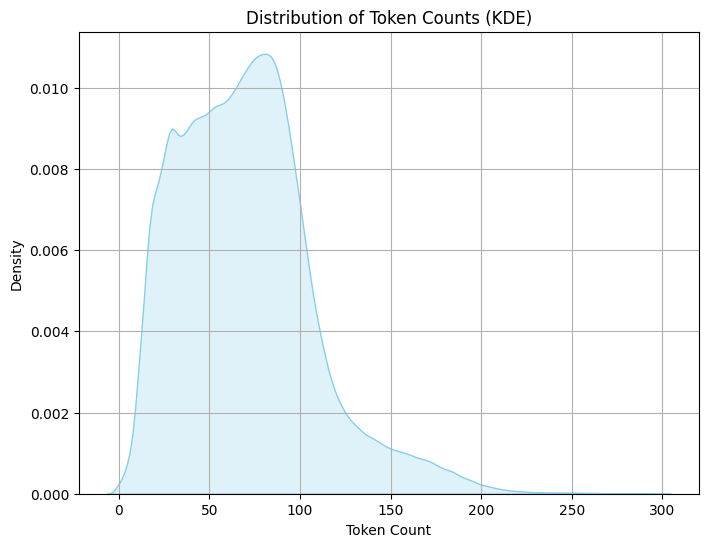

In [70]:
plot_token_count_kde(df, 'token_count')


## **Diseño de modelos machine learning**

In [71]:
def data_transform(df: pd.DataFrame):
    df = df.dropna(subset=['textCls', 'sentimiento'])
    X = df['textCls']
    y = df['sentimiento']
    return X, y

In [72]:
def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    return labels.map(idx2label)

In [82]:
def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, '../data/modelos/count_vectorizer.pkl')
    return X_vectorized

In [85]:
def transform_tfidf(X_vectorized: object) -> np.ndarray:
    vec = TfidfTransformer()
    X_tfidf = vec.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, '../data/modelos/X_tfidf.pkl')
    #logger.info("X_tfidf trained successfully stored")
    return X_tfidf

In [86]:
def save_pickle(data, filename) -> None:
    filepath = os.path.join("../data", "modelos", f"{filename}.pkl")
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)

In [76]:
def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    save_pickle((X_train, y_train), "train")
    save_pickle((X_test, y_test),  "test")
    return X_train, X_test, y_train, y_test

In [77]:
def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    
    idx2label = {'positivo': 0, 'negativo': 1, 'neutral': 2}
    # star experiment in mlflow
    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)
        
        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        logger.info(f"ROC AUC Score Train: {roc_auc_score_train}")
        logger.info(f"ROC AUC Score Test: {roc_auc_score_test}")
        
        
        # adding the metrics to the list
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            logger.info(f"Error: {e}")

        #mlflow.sklearn.log_model(model, f"model_{name_model}")
        signature = infer_signature(X_test, y_test_pred)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=f"model_{name_model}",
            input_example=X_test[:5],
            signature=signature
        )

        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        label_map = {v: k for k, v in idx2label.items()}

        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded
        decoded_y_test_pred = [label_map[idx] for idx in y_test_pred]
        decoded_y_test = [label_map[idx] for idx in y_test]

        #decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        #decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(label_map.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        #mlflow.sklearn.log_model(model, f"models/{name_model}")
        signature = infer_signature(X_test, y_test_pred)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=f"models_{name_model}",
            input_example=X_test[:5],
            signature=signature
        )

        return metric

In [78]:
idx2label = {'positivo': 0, 'negativo': 1, 'neutral': 2}

X, y = data_transform(df)
Y = decode_labels_into_idx(labels=y, idx2label=idx2label)

In [87]:
X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, Y)

## **Modelo Stochastic Gradient Descent Classifier (SGD)**

INFO:__main__:ROC AUC Score Train: 0.93
INFO:__main__:ROC AUC Score Test: 0.93


Train Accuracy:  0.81
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85    439148
           1       0.85      0.63      0.72    290821
           2       0.74      0.93      0.82    346521

    accuracy                           0.81   1076490
   macro avg       0.82      0.80      0.80   1076490
weighted avg       0.82      0.81      0.81   1076490

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84    187545
           1       0.85      0.63      0.72    124934
           2       0.74      0.92      0.82    148874

    accuracy                           0.81    461353
   macro avg       0.81      0.79      0.80    461353
weighted avg       0.82      0.81      0.80    461353



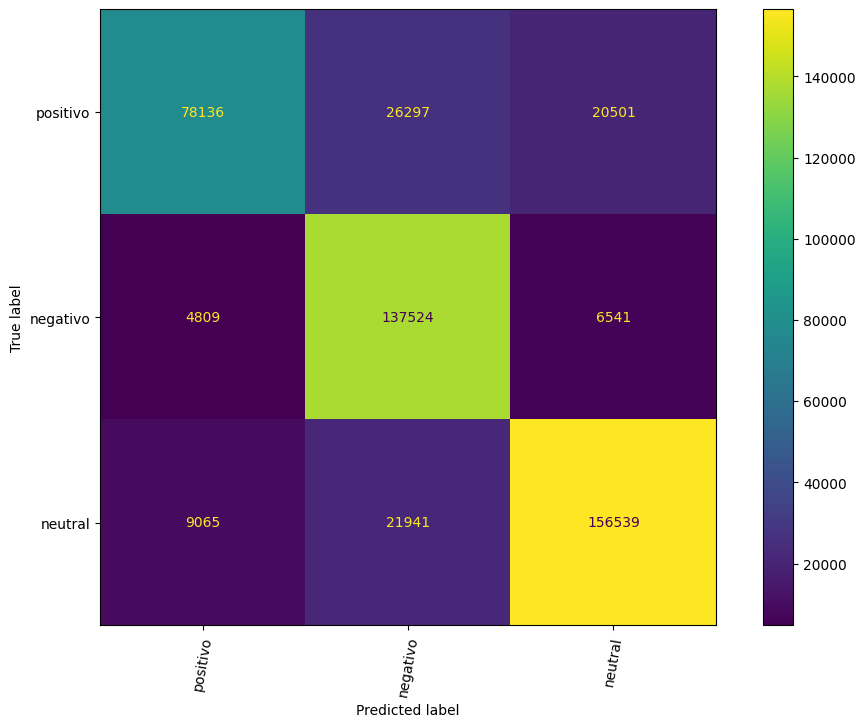

[np.float64(0.93),
 np.float64(0.93),
 0.81,
 0.81,
 0.82,
 0.82,
 0.81,
 0.81,
 0.81,
 0.8]

In [91]:
mnb2 = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
mnb2.fit(X_train, y_train)
display_classification_report(model=mnb2, 
                              name_model="SGDClassifier", 
                              developer="Ivan Camilo Rosales", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

## **Modelo Multinomial Naive Bayes**

INFO:__main__:ROC AUC Score Train: 0.95
INFO:__main__:ROC AUC Score Test: 0.92


Train Accuracy:  0.72
Test Accuracy:  0.67
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.61      0.97      0.74    439148
           1       0.91      0.60      0.73    290821
           2       0.94      0.49      0.64    346521

    accuracy                           0.72   1076490
   macro avg       0.82      0.69      0.70   1076490
weighted avg       0.80      0.72      0.71   1076490

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.56      0.96      0.71    187545
           1       0.88      0.54      0.67    124934
           2       0.91      0.40      0.56    148874

    accuracy                           0.67    461353
   macro avg       0.78      0.63      0.65    461353
weighted avg       0.76      0.67      0.65    461353



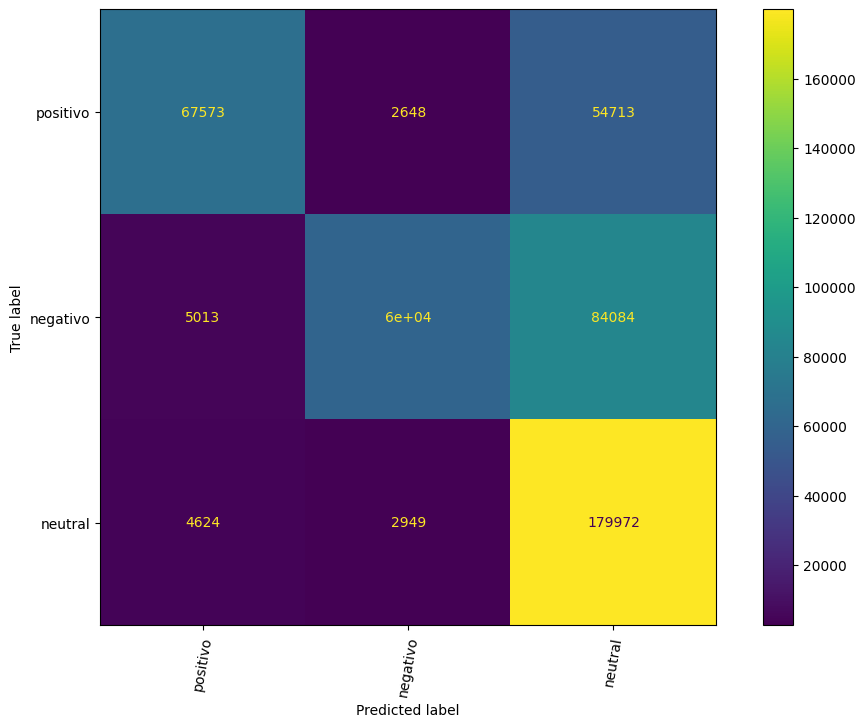

[np.float64(0.95),
 np.float64(0.92),
 0.72,
 0.67,
 0.8,
 0.76,
 0.72,
 0.67,
 0.71,
 0.65]

In [92]:
mnb3 = MultinomialNB()
mnb3.fit(X_train, y_train)
display_classification_report(model=mnb3, 
                              name_model="MultinomialNB", 
                              developer="Ivan Camilo Rosales", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

## **Modelo Regresión Logística**

INFO:__main__:ROC AUC Score Train: 0.98
INFO:__main__:ROC AUC Score Test: 0.97


Train Accuracy:  0.94
Test Accuracy:  0.93
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95    439148
           1       0.92      0.91      0.92    290821
           2       0.97      0.95      0.96    346521

    accuracy                           0.94   1076490
   macro avg       0.94      0.94      0.94   1076490
weighted avg       0.94      0.94      0.94   1076490

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94    187545
           1       0.91      0.89      0.90    124934
           2       0.95      0.95      0.95    148874

    accuracy                           0.93    461353
   macro avg       0.93      0.93      0.93    461353
weighted avg       0.93      0.93      0.93    461353



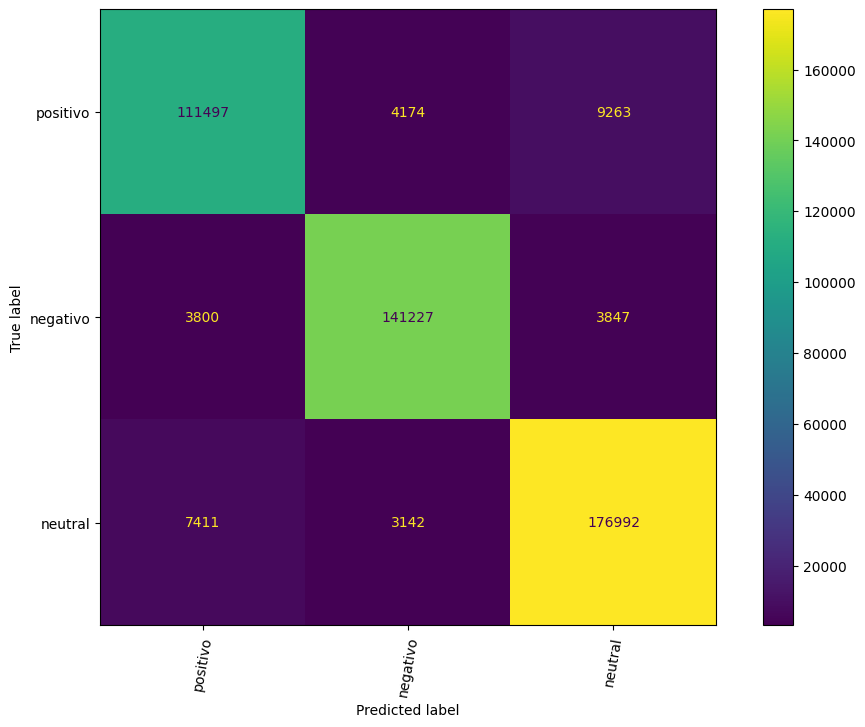

[np.float64(0.98),
 np.float64(0.97),
 0.94,
 0.93,
 0.94,
 0.93,
 0.94,
 0.93,
 0.94,
 0.93]

In [93]:
mnb = LogisticRegression(solver='saga', C=1.0, max_iter=1000, n_jobs=-1)
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="LogisticRegression", 
                              developer="Ivan Camilo Rosales", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

In [ ]:
""" mnb4 = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', max_depth=None,min_samples_split=2)
mnb4.fit(X_train, y_train)
display_classification_report(model=mnb4, 
                              name_model="RandomForestClassifier", 
                              developer="Ivan Camilo Rosales", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test) """

In [ ]:
""" mnb5 = OneVsOneClassifier(SVC(kernel='rbf',gamma=1,C=10))
mnb5.fit(X_train, y_train)
display_classification_report(model=mnb5, 
                              name_model="OneVsOneClassifier", 
                              developer="Ivan Camilo Rosales", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test) """